## Cluster Studies (Jan)

Here is an updated version of the ClusterStudies.ipynb notebook, using uproot4 and newer versions of our plotting utilities.

This notebook is designed to use ntuples produced by the image-based version of MLTree (i.e. not the latest version of MLTree, that makes graph-friendly data with a different format).

In [1]:
#import libraries and some constants
import os, sys, pathlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import ROOT as rt # I will use this for some plotting
import uproot as ur
from numba import jit, njit

path_prefix = os.getcwd() + '/../'
plotpath = '{}/Plots/'.format(os.getcwd())

try: os.makedirs(plotpath)
except: pass

if(path_prefix not in sys.path): sys.path.append(path_prefix)
from util import plot_util as pu
from util import ml_util as mu
from util import qol_util as qu

# some of our classification/regression-specific utils have useful functions
from util.classification import plot_util as cpu

# metadata
layers = ["EMB1", "EMB2", "EMB3", "TileBar0", "TileBar1", "TileBar2"]
cell_size_phi = [0.098, 0.0245, 0.0245, 0.1, 0.1, 0.1]
cell_size_eta = [0.0031, 0.025, 0.05, 0.1, 0.1, 0.2]
len_phi = [4, 16, 16, 4, 4, 4]
len_eta = [128, 16, 8, 4, 4, 2]
cell_shapes = {layers[i]:(len_eta[i],len_phi[i]) for i in range(len(layers))}
cell_widths = {layers[i]:(cell_size_eta[i],cell_size_phi[i]) for i in range(len(layers))}

Welcome to JupyROOT 6.24/00


In [2]:
source = 'pion'

if(source == 'pion'):
    inputpath=path_prefix+'data/pion/'
    rootfiles = {        
        'p0':inputpath + 'user.mswiatlo.900246.PG_singlepi0_logE0p2to2000.recon.ESD.e8312_e7400_s3170_r12383.images_v01.1_OutputStream/*.root',
        'pp':inputpath + 'user.mswiatlo.900247.PG_singlepion_logE0p2to2000.recon.ESD.e8312_e7400_s3170_r12383.images_v01.1_OutputStream/*.root'
    }
    
    branches = [
                'clusterE', 'clusterECalib', 
                'clusterPt', 'clusterEta', 'clusterPhi', 
                'cluster_nCells', 'cluster_sumCellE', 
                'cluster_ENG_CALIB_TOT', 'cluster_EM_PROBABILITY'
    ]  
else: assert(False)
    
# fancy display names for each pion type
pi_text = {
    'p0': 'pi0',
    'pp': 'pi +/-'
}

pi_latex = {
    'p0': '#pi^{0}',
    'pp': '#pi^{#pm}',
}
pi_latex_plt = {
    'p0': '$\pi^{0}$',
    'pp': '$\pi^{\pm}$'
}

# Plotting settings
# xkcd -- turn this on for fun-looking (but marginally less useful) plots
use_xkcd = False
if(use_xkcd):
    mode = 'light'
    plt.xkcd(scale=.75,length=100,randomness=1)
    
# plotting style -- manages our color palette and object colors
mode = 'dark' # for publications, use "light"
plotstyle = qu.PlotStyle(mode)
plotstyle.SetStyle()
    
# some matplotlib-specific stuff
params = {'legend.fontsize': 13,
          'axes.labelsize': 16,
          'axes.titlesize': 18
         }
plt.rcParams.update(params)

In [3]:
# Prepare data
h5_name_suffix = 'tdata'
h5_name = inputpath + h5_name_suffix

pdata,pcells = mu.setupPionData(
    rootfiles, 
    branches=branches, 
    layers=layers, 
    balance_data=True, 
    n_max = 300000,
    verbose=True,
    load=True,
    save=True,
    filename=h5_name,
    match_distribution='cluster_ENG_CALIB_TOT',
    match_binning = (20000,0.,2000.),
    cut_distributions=['cluster_ENG_CALIB_TOT','clusterEta'],
    cut_values = [.2, (-0.7,0.7)],
    cut_types=['lower','window']
)

total = np.sum([len(x) for x in pdata.values()],dtype=int)
for key,frame in pdata.items():
    n = len(frame)
    print("Number of {a:<7} events: {b:>10}\t({c:.1f}%)".format(a=pi_text[key], b = n, c = 100. * n / total))
print("Total: {}".format(total))

Loading pandas DataFrame and calo images from /local/home/jano/ml4pions/LCStudies/clusters/../data/pion/tdata_frame.h5 and /local/home/jano/ml4pions/LCStudies/clusters/../data/pion/tdata_images.h5.
Number of pi0     events:     300000	(50.0%)
Number of pi +/-  events:     300000	(50.0%)
Total: 600000


### Plotting basic kinematics

First, let's plot some basic kinematics from this data. This code is lifted from our classification workflow.

Let's fetch the data we want to look at. We'll need to change the code below depending on what dataset we're inspecting (and however you've stored it on your system).

Info in <TCanvas::Print>: png file /local/home/jano/ml4pions/LCStudies/clusters/Plots/hist_pi0_plus_minus.png has been created


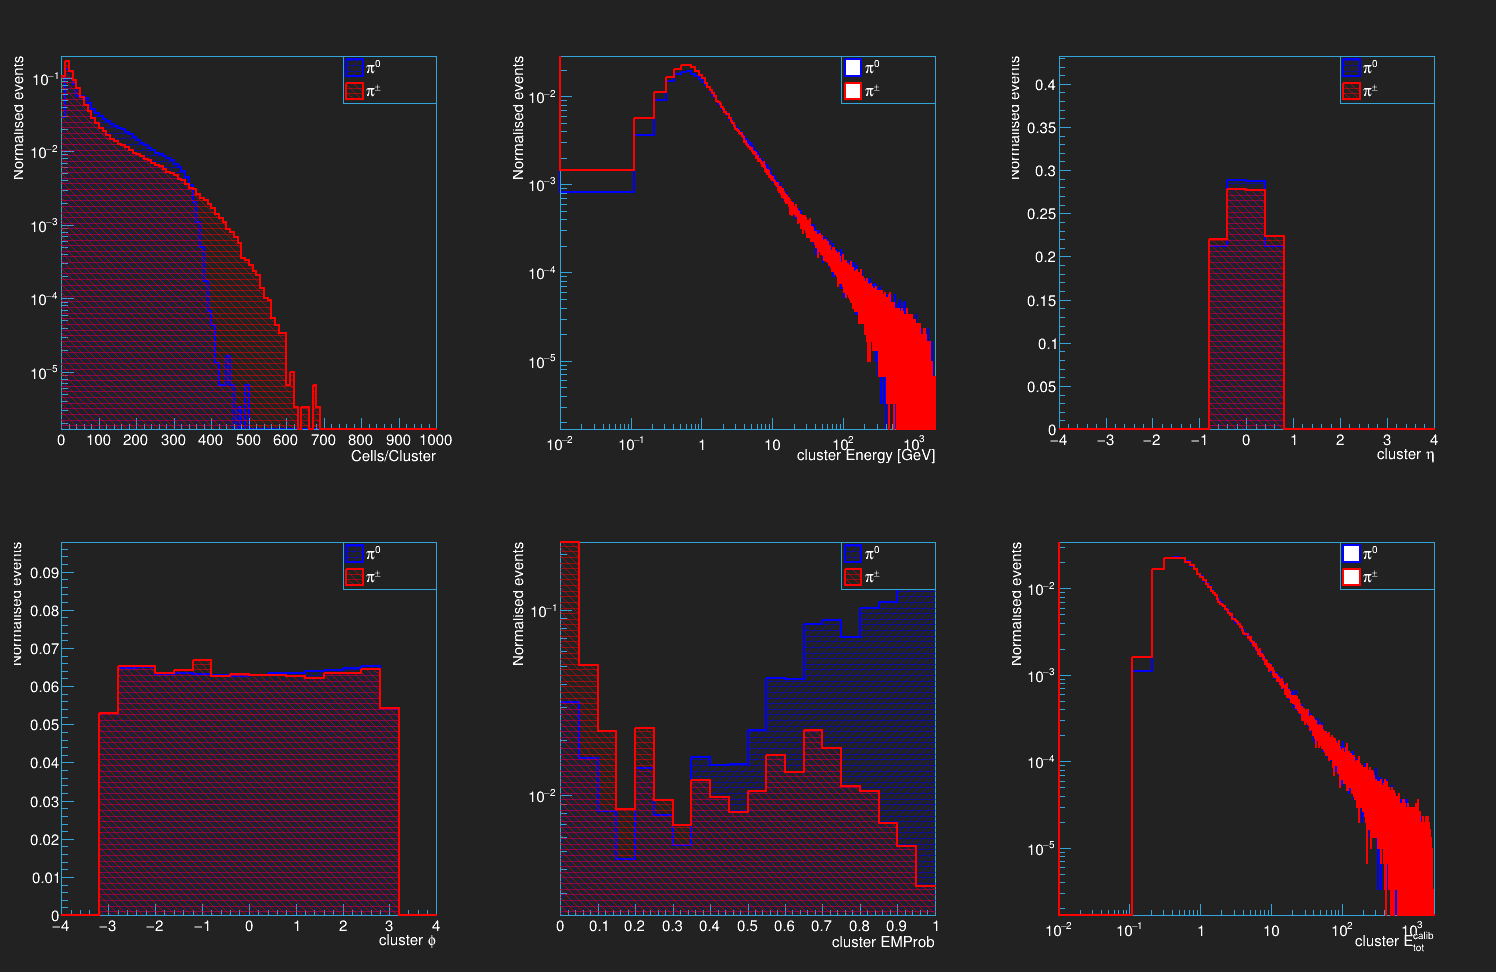

In [4]:
rt.gStyle.SetOptStat(0)
plotstyle.SetStyle()

#if(drawPlots):
# For storing histograms and legends, to prevent overwriting. (TODO: Probably better ways to do this in PyROOT)
histos = []
legends = []

# Exhaustive list of quantities we want to plot. Note that some will not be available, depending on dataset provenance/age.
n_bins_small = 20
n_bins_med = 100
n_bins_large = int(2e4)
qtys = [
    ('cluster_nCells','Cells/Cluster',(n_bins_med,0,1000)),
    ('clusterE','cluster Energy [GeV]',(n_bins_large,1.0e-2,2.0e3)),
    ('clusterEta','cluster #eta',(n_bins_small,-4.,4.)),
    ('clusterPhi','cluster #phi',(n_bins_small,-4.,4.)),
    ('cluster_EM_PROBABILITY','cluster EMProb',(n_bins_small,0.,1.)),
    #('cluster_sumCellE','cluster SumCellE',(n_bins_small,0.,2500.)),
    ('cluster_ENG_CALIB_TOT','cluster E^{calib}_{tot}',(n_bins_large,1.0e-2,2.0e3))
]

log_x = ['clusterE', 'cluster_ENG_CALIB_TOT']
log_y = ['cluster_nCells','clusterE', 'cluster_EM_PROBABILITY', 'cluster_sumCellE', 'cluster_ENG_CALIB_TOT']

qtys = [x for x in qtys if x[0] in branches]

qty_labels = [x[1] for x in qtys]
qty_ranges = [x[2] for x in qtys]
qtys =       [x[0] for x in qtys]

# Set up a canvas.
plot_size = 500
nx = int(np.ceil(len(qtys) / 2))
ny = 2
n_pad = nx * ny
canvas = rt.TCanvas('cluster_hists','c1',plot_size * nx,plot_size * ny)
canvas.Divide(nx,ny)

colors = {'pp':rt.kRed,'p0':rt.kBlue}
styles = {'pp':3440, 'p0':3404}

n_bins=20
for i, (qty, label, rng) in enumerate(zip(qtys, qty_labels, qty_ranges)):
    canvas.cd(i+1)
    leg = rt.TLegend(0.7,0.8,0.9,0.9)
    leg.SetTextColor(plotstyle.text)
    for ptype, p in pdata.items():
        hist = rt.TH1F('h_'+str(ptype)+'_'+str(qty),'',rng[0],rng[1],rng[2])
        for entry in p[qty]: hist.Fill(entry)
        integral = hist.Integral()
        if(integral != 0): hist.Scale(1./hist.Integral())
        hist.SetLineColor(colors[ptype])
        hist.SetLineWidth(2)

        if(qty not in log_x):
            hist.SetFillColorAlpha(colors[ptype],0.5)
            hist.SetFillStyle(styles[ptype])

        hist.Draw('HIST SAME')
        hist.GetXaxis().SetTitle(label)
        hist.GetYaxis().SetTitle('Normalised events')
        hist.SetMaximum(1.5 * hist.GetMaximum())
        leg.AddEntry(hist,pi_latex[ptype],'f')
        leg.Draw()
        histos.append(hist)
        legends.append(leg)

    if(qty in log_x): rt.gPad.SetLogx()
    if(qty in log_y): rt.gPad.SetLogy()
canvas.Draw()

canvas.SaveAs(plotpath+'hist_pi0_plus_minus.png')

Besides these simple 1d histograms, we might also want to see how the different variables correlate with one another. For example, what's the relationship between reconstruction-level energy (`clusterE`) and calibration hits (`cluster_ENG_CALIB_TOT`)?

Info in <TCanvas::Print>: png file /local/home/jano/ml4pions/LCStudies/clusters/Plots/energy_vs_calib_hits.png has been created


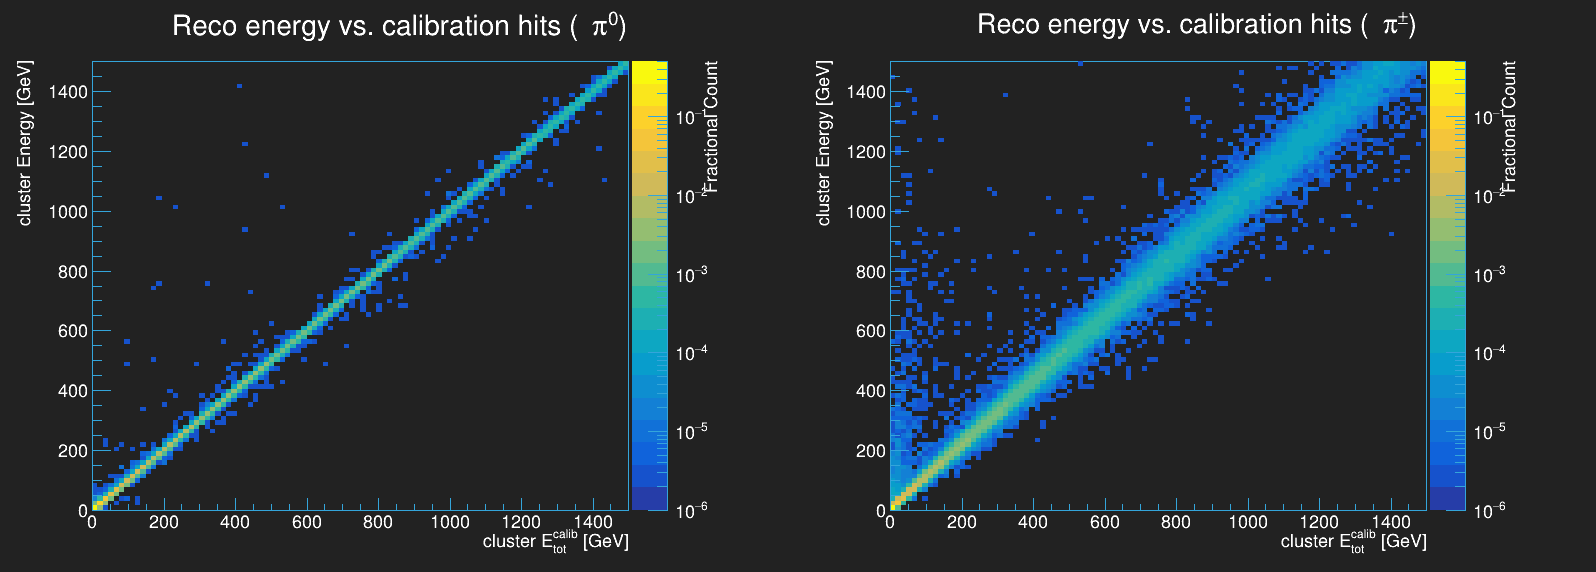

In [5]:
nbins = 100
e_min = 0.
e_max = 1.5e3
canvas = rt.TCanvas(qu.RN(),'c',1600,600)

# 2D histograms
h2d = {
    key: rt.TH2F(qu.RN(), 'Reco energy vs. calibration hits ({})'.format(pi_latex[key]) + ';cluster E_{tot}^{calib} [GeV];cluster Energy [GeV];Fractional Count', nbins, e_min, e_max, nbins, e_min, e_max)
    for key in pdata.keys()
}
canvas.Divide(2,1)

for key,frame in pdata.items():
    for entry in frame[['clusterE','cluster_ENG_CALIB_TOT']].to_numpy():
        h2d[key].Fill(*entry)
        
for i,key in enumerate(pdata.keys()):
    # rescale our histograms
    h2d[key].Scale(1./h2d[key].Integral())
    canvas.cd(i+1)
    h2d[key].Draw('COLZ')
    rt.gPad.SetRightMargin(0.2)
    rt.gPad.SetLogz()
    h2d[key].SetMinimum(1.0e-6)
    h2d[key].SetMaximum(5.0e-1)
canvas.Draw()
canvas.SaveAs(plotpath + 'energy_vs_calib_hits.png')

Info in <TCanvas::Print>: png file /local/home/jano/ml4pions/LCStudies/clusters/Plots/diff_energy_calib_hits.png has been created


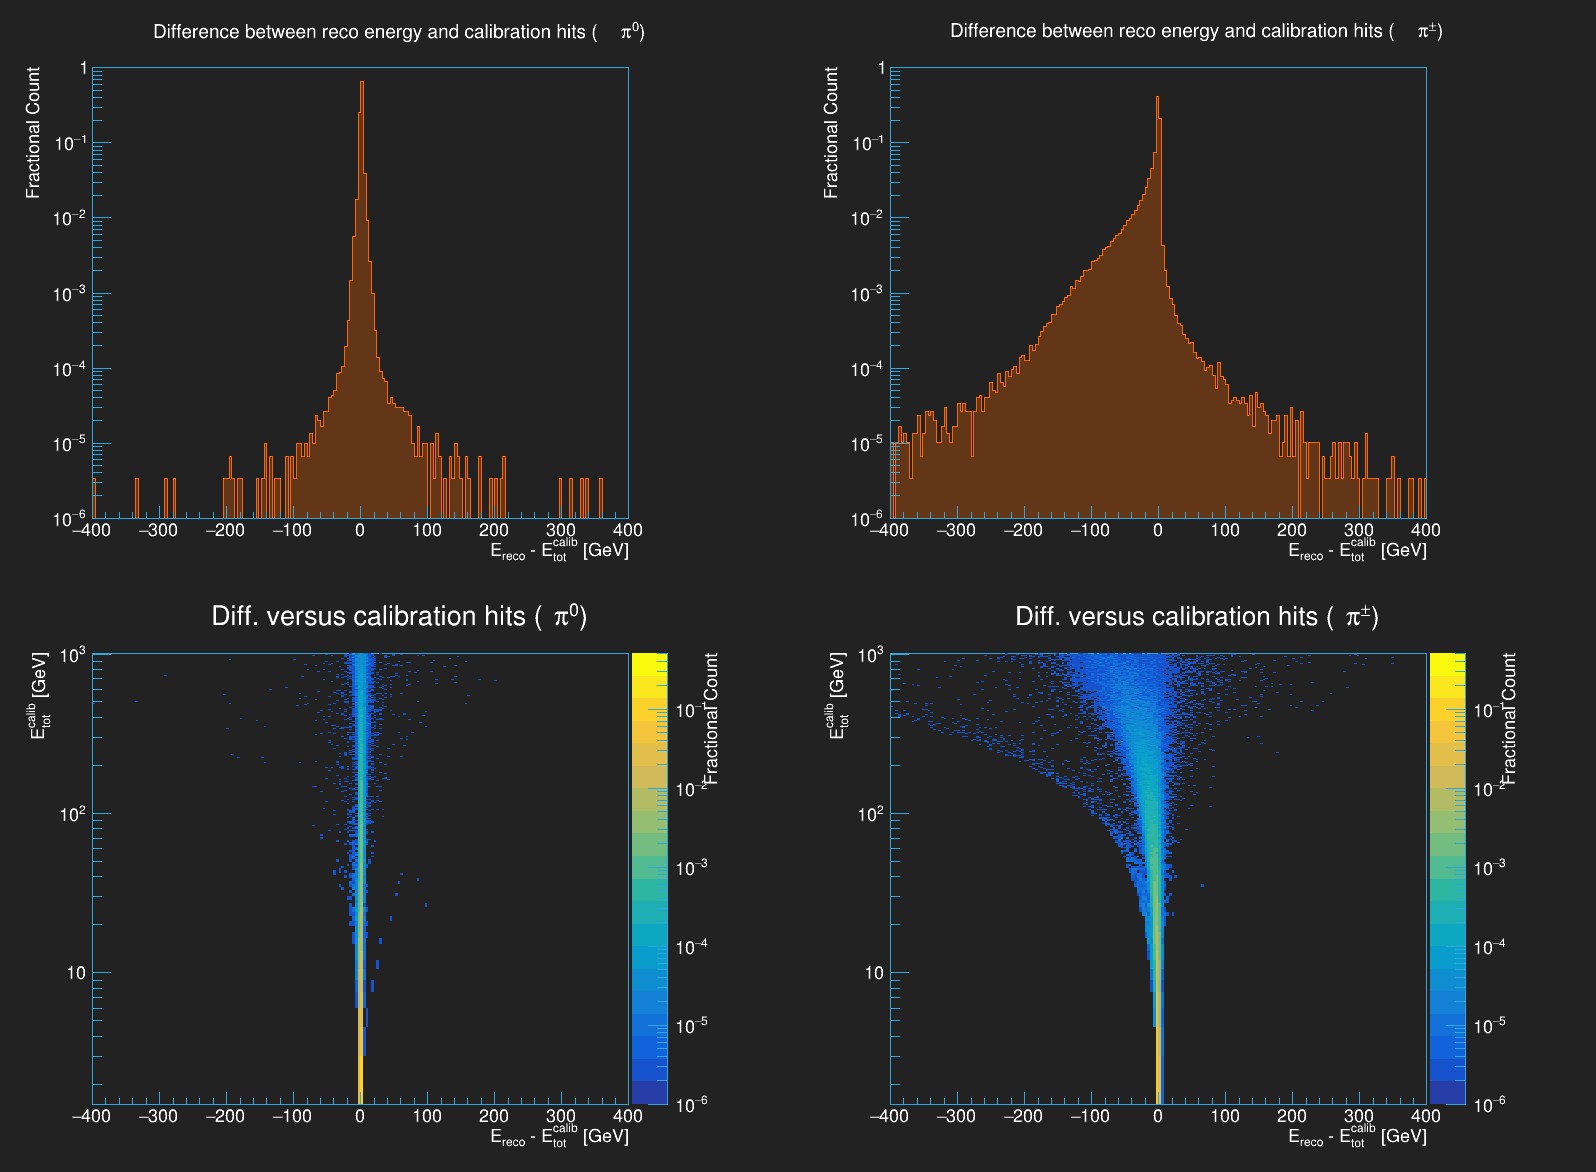

In [6]:
canvas = rt.TCanvas(qu.RN(),'c',1600,1200)
canvas.Divide(2,2)

nbins = 200
x_min = -400.
x_max = -1.0 * x_min
# 1d histograms -- differences between reco energy and calib hits
h = {
    key:rt.TH1F(qu.RN(), 'Difference between reco energy and calibration hits ({})'.format(pi_latex[key]) + ';E_{reco} - E_{tot}^{calib} [GeV]; Fractional Count',nbins, x_min, x_max)
    for key in pdata.keys()
}

# 2d histograms -- difference vs calibration hits
h2d = {
    key:rt.TH2F(qu.RN(), 'Diff. versus calibration hits ({})'.format(pi_latex[key]) + ';E_{reco} - E_{tot}^{calib} [GeV]; E_{tot}^{calib} [GeV]; Fractional Count',nbins, x_min, x_max, 1000, e_min, e_max)
    for key in pdata.keys()
}

for key,frame in pdata.items():
    for entry in frame[['clusterE','cluster_ENG_CALIB_TOT']].to_numpy():
        h[key].Fill(entry[0]-entry[1])
        h2d[key].Fill(entry[0]-entry[1], entry[1])

for i,key in enumerate(pdata.keys()):

    # 1D histogram
    h[key].Scale(1./h[key].Integral())
    canvas.cd(i+1)
    h[key].Draw('HIST')
    h[key].SetMinimum(1.0e-6)
    h[key].SetMaximum(1.0)
    h[key].SetLineColor(plotstyle.curve)
    h[key].SetFillColorAlpha(plotstyle.curve, 0.3)
    rt.gPad.SetLogy()
    rt.gPad.SetRightMargin(0.2)
    
    # 2D histogram
    h2d[key].Scale(1./h2d[key].Integral())
    canvas.cd(i+3)
    h2d[key].Draw('COLZ')
    h2d[key].SetMinimum(1.0e-6)
    h2d[key].SetMaximum(5.0e-1)
    rt.gPad.SetLogy()
    rt.gPad.SetLogz()
    rt.gPad.SetRightMargin(0.2)
    h2d[key].GetYaxis().SetRangeUser(0.1,1.0e3)
    
canvas.Draw()
canvas.SaveAs(plotpath + 'diff_energy_calib_hits.png')

We might also want to look at percentage differences. This is also something we've investigated in other notebooks (e.g. when seeing how well our predicted energies perform), but we might visualize things a bit differently here.

Info in <TCanvas::Print>: png file /local/home/jano/ml4pions/LCStudies/clusters/Plots/percent_diff_energy_calib_hits.png has been created


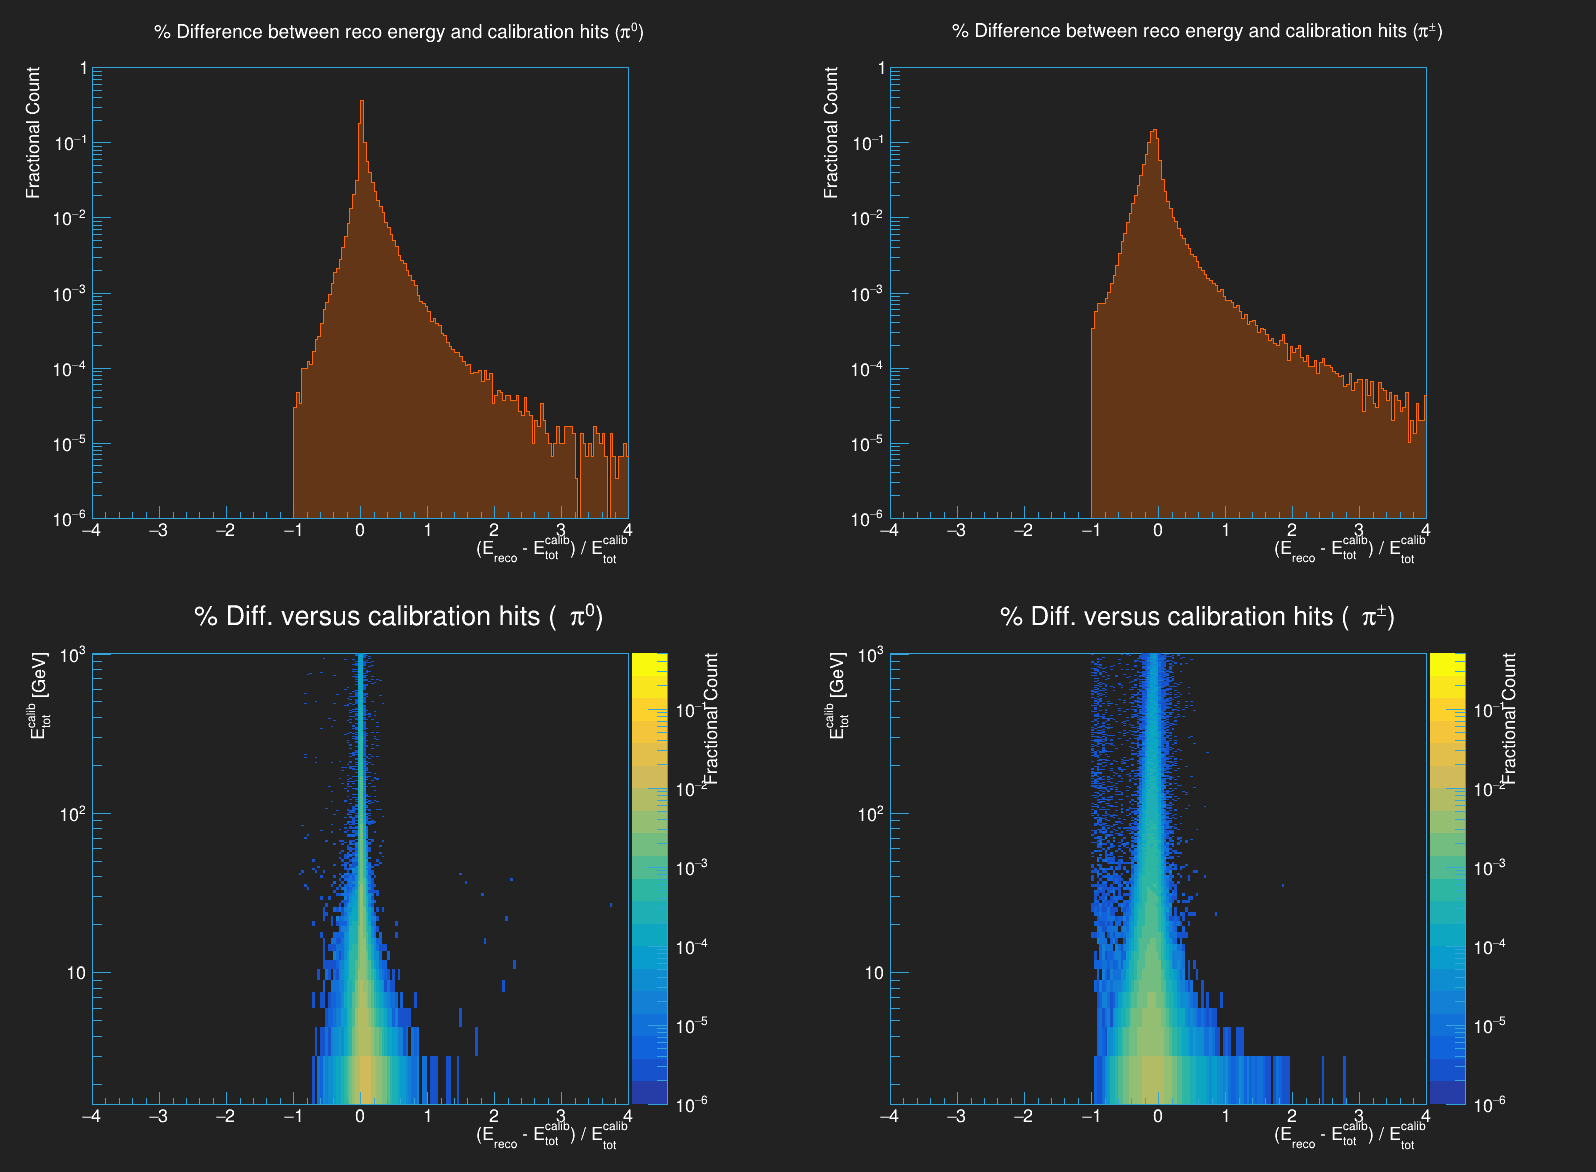

In [7]:
canvas = rt.TCanvas(qu.RN(),'c',1600,1200)
canvas.Divide(2,2)

nbins = 200
x_min = -4.
x_max = -1.0 * x_min
# 1d histograms -- differences between reco energy and calib hits
h = {
    key:rt.TH1F(qu.RN(), '% Difference between reco energy and calibration hits ({})'.format(pi_latex[key]) + ';(E_{reco} - E_{tot}^{calib}) / E_{tot}^{calib}; Fractional Count',nbins, x_min, x_max)
    for key in pdata.keys()
}

# 2d histograms -- difference vs calibration hits
h2d = {
    key:rt.TH2F(qu.RN(), '% Diff. versus calibration hits ({})'.format(pi_latex[key]) + ';(E_{reco} - E_{tot}^{calib}) / E_{tot}^{calib}; E_{tot}^{calib} [GeV]; Fractional Count',nbins, x_min, x_max, 1000, e_min, e_max)
    for key in pdata.keys()
}

for key,frame in pdata.items():
    for entry in frame[['clusterE','cluster_ENG_CALIB_TOT']].to_numpy():
        if(entry[1] != 0.):
            h[key].Fill((entry[0]-entry[1])/entry[1])
            h2d[key].Fill((entry[0]-entry[1])/entry[1], entry[1])

for i,key in enumerate(pdata.keys()):

    # 1D histogram
    h[key].Scale(1./h[key].Integral())
    canvas.cd(i+1)
    h[key].Draw('HIST')
    h[key].SetMinimum(1.0e-6)
    h[key].SetMaximum(1.0)
    h[key].SetLineColor(plotstyle.curve)
    h[key].SetFillColorAlpha(plotstyle.curve, 0.3)
    rt.gPad.SetLogy()
    rt.gPad.SetRightMargin(0.2)
    
    # 2D histogram
    h2d[key].Scale(1./h2d[key].Integral())
    canvas.cd(i+3)
    h2d[key].Draw('COLZ')
    h2d[key].SetMinimum(1.0e-6)
    h2d[key].SetMaximum(5.0e-1)
    rt.gPad.SetLogy()
    rt.gPad.SetLogz()
    rt.gPad.SetRightMargin(0.2)
    h2d[key].GetYaxis().SetRangeUser(0.1,1.0e3)

canvas.Draw()
canvas.SaveAs(plotpath + 'percent_diff_energy_calib_hits.png')

We can also look at the % difference between reco energy and calibration hits, as a function of $\eta$ and $\phi$. We don't expect a trend in the latter but it's nice to check. Given our limited $\eta$ range we may also not see much of a trend there.

Info in <TCanvas::Print>: png file /local/home/jano/ml4pions/LCStudies/clusters/Plots/percent_diff_energy_calib_hits_2.png has been created


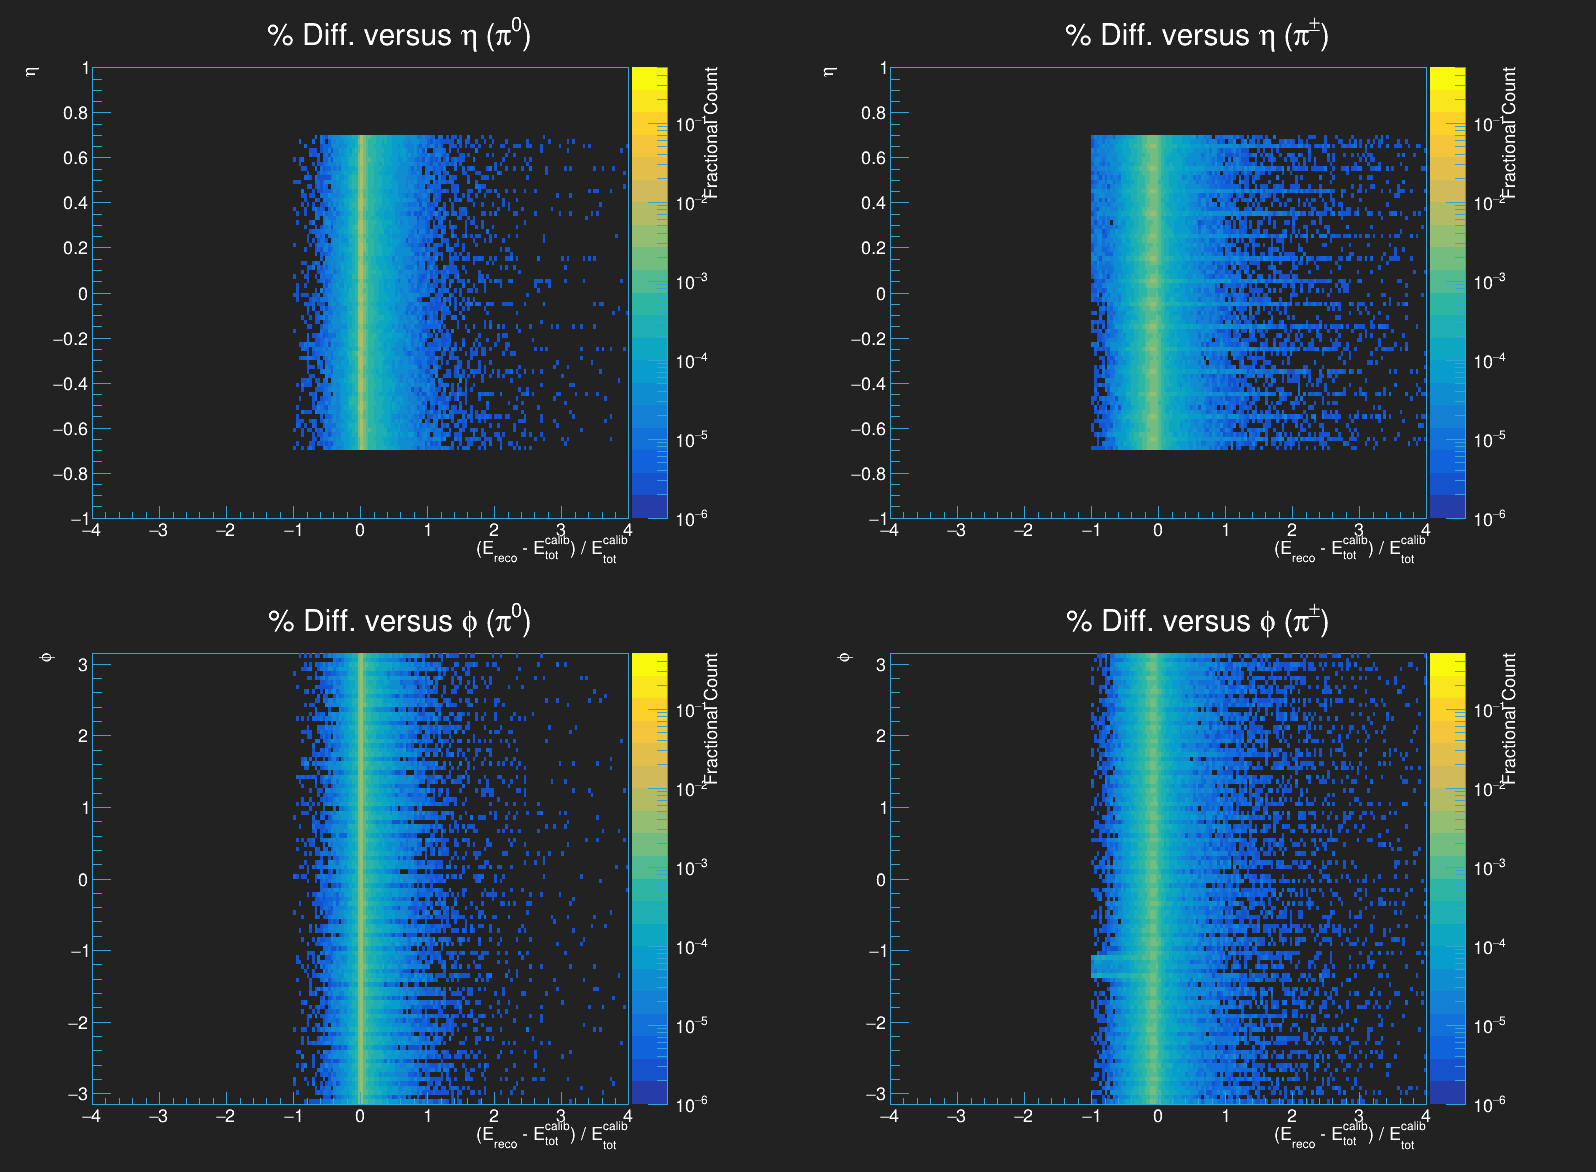

In [8]:
canvas = rt.TCanvas(qu.RN(),'c',1600,1200)
canvas.Divide(2,2)

nbins = 200
x_min = -4.
x_max = -1.0 * x_min

# 2d histograms -- difference vs eta
h2d1 = {
    key:rt.TH2F(qu.RN(), '% Diff. versus #eta ({})'.format(pi_latex[key]) + ';(E_{reco} - E_{tot}^{calib}) / E_{tot}^{calib}; #eta; Fractional Count',nbins, x_min, x_max, 100, -1., 1.)
    for key in pdata.keys()
}

# 2d histograms -- difference vs phi
h2d2 = {
    key:rt.TH2F(qu.RN(), '% Diff. versus #phi ({})'.format(pi_latex[key]) + ';(E_{reco} - E_{tot}^{calib}) / E_{tot}^{calib}; #phi; Fractional Count',nbins, x_min, x_max, 100, -1. * np.pi, np.pi)
    for key in pdata.keys()
}

for key,frame in pdata.items():
    for entry in frame[['clusterEta', 'clusterPhi', 'clusterE', 'cluster_ENG_CALIB_TOT']].to_numpy():
        if(entry[2] != 0.):
            
            ratio = (entry[2] - entry[3]) / entry[3]
            h2d1[key].Fill(ratio,entry[0])
            h2d2[key].Fill(ratio,entry[1])

for i,key in enumerate(pdata.keys()):
    
    # vs eta
    h2d1[key].Scale(1./h2d1[key].Integral())
    canvas.cd(i+1)
    h2d1[key].Draw('COLZ')
    h2d1[key].SetMinimum(1.0e-6)
    h2d1[key].SetMaximum(5.0e-1)
    #rt.gPad.SetLogy()
    rt.gPad.SetLogz()
    rt.gPad.SetRightMargin(0.2)
    #h2d1[key].GetYaxis().SetRangeUser(0.1,1.0e3)
    
    # vs phi
    h2d2[key].Scale(1./h2d2[key].Integral())
    canvas.cd(i+3)
    h2d2[key].Draw('COLZ')
    h2d2[key].SetMinimum(1.0e-6)
    h2d2[key].SetMaximum(5.0e-1)
    #rt.gPad.SetLogy()
    rt.gPad.SetLogz()
    rt.gPad.SetRightMargin(0.2)
    #h2d2[key].GetYaxis().SetRangeUser(0.1,1.0e3)    

canvas.Draw()
canvas.SaveAs(plotpath + 'percent_diff_energy_calib_hits_2.png')

Pretty colors, but not that much to take away from these plots -- things look pretty uniform in $\eta$ and $\phi$ (we see some repeated "streaks", which may have to do with detector granularity in these coordinates?). There's a bit of a blip in the $\phi$ plot for $\pi^\pm$, but I wouldn't make much of this (esp. as our detector has discrete rotational symmetry in $\phi$).

### Plotting average images

Let's now look at the average images for our dataset. 

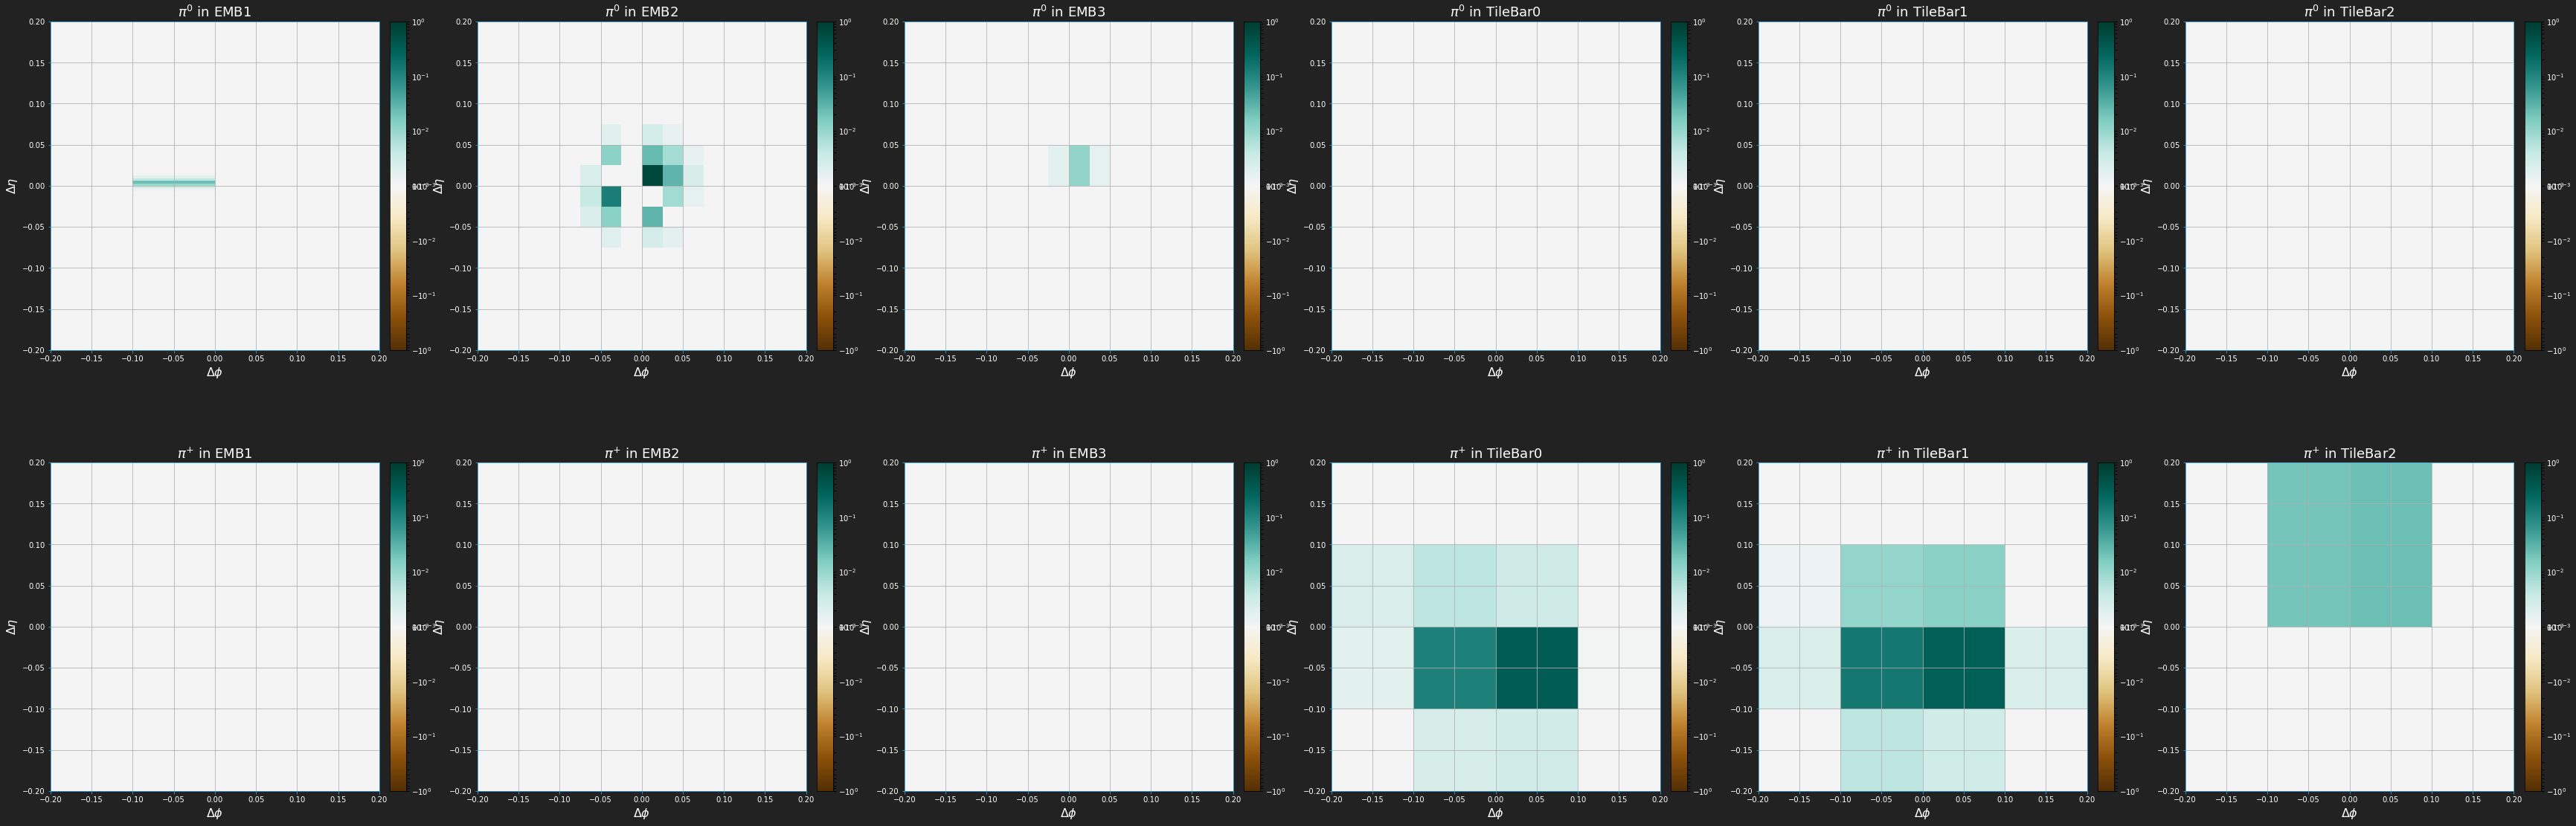

In [9]:
cpu.ImagePlot(
    pcells,
    cluster=-1, # do average
    plotpath=plotpath,
    filename='calo_images.png',
    dynamic_range=False,
    plotstyle=plotstyle
)

We can also make ROOT-style plots. Note that one thing currently missing from ROOT is the ability to use a symlog axis -- though we might expect that for average images, there won't be negative values anyway. ([Hopefully this will be added soon](https://root-forum.cern.ch/t/symlog-scale-for-plotting/45021)!)

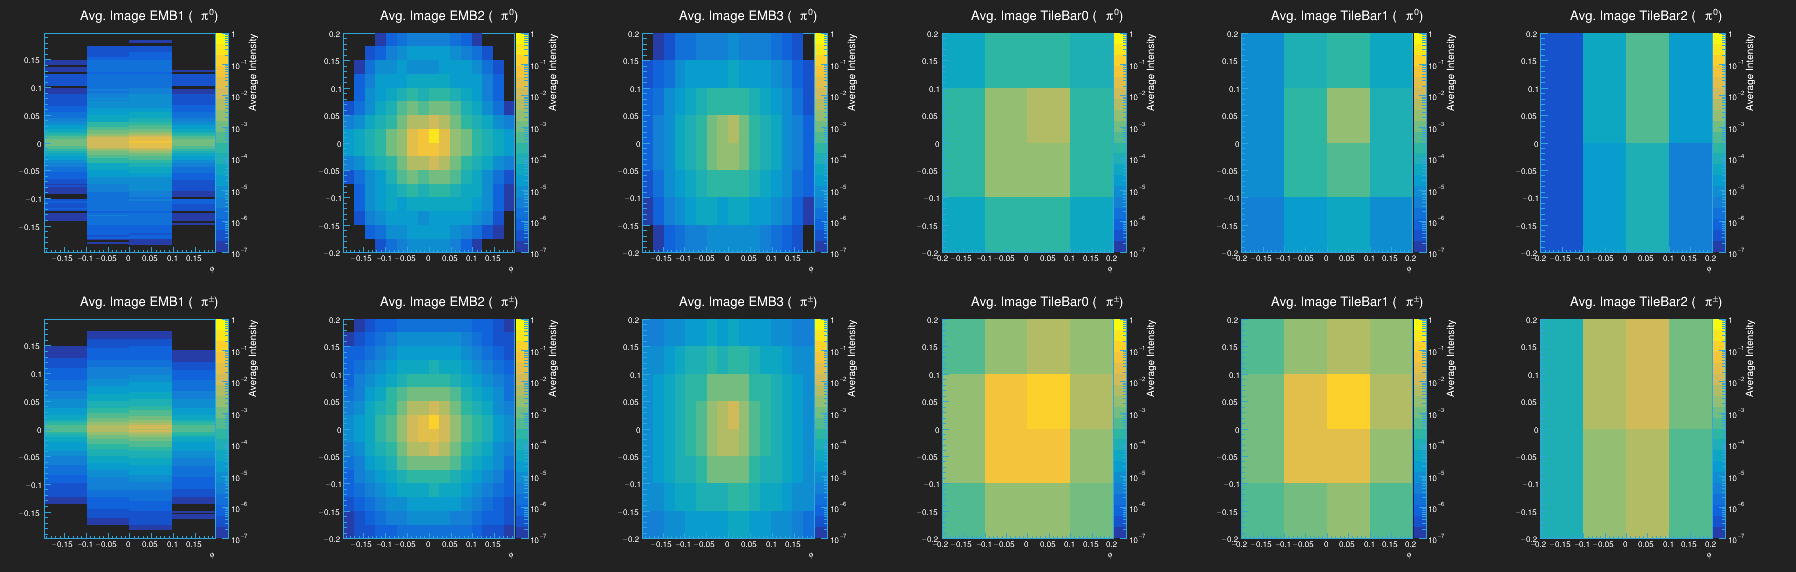

In [52]:
d = 300
c = rt.TCanvas(qu.RN(), 'c',6 * d,2 * d)
c.Divide(6,2)

hists = {}
i = 0
for key in pdata.keys():
    hists[key] = {
        layer:rt.TH2F(qu.RN(),
                      'Avg. Image {} ({})'.format(layer,pi_latex[key]) + ';#phi;#eta;Average Intensity',
                      meta['len_phi'], 
                      -0.5 * meta['len_phi'] * meta['cell_size_phi'],
                       0.5 * meta['len_phi'] * meta['cell_size_phi'],
                      meta['len_eta'], 
                      -0.5 * meta['len_eta'] * meta['cell_size_eta'],
                       0.5 * meta['len_eta'] * meta['cell_size_eta']
                     )
        for layer,meta in mu.cell_meta.items()
    }
    
    for layer,h in hists[key].items():
        c.cd(i+1)
        lx, ly = mu.cell_meta[layer]['len_phi'], mu.cell_meta[layer]['len_eta']
        avg_image = np.mean(pcells[key][layer],axis=0).reshape(ly, lx)
        
        for j in range(lx):
            for k in range(ly):
                h.SetBinContent(j+1,k+1,avg_image[k,j])
        
        h.GetZaxis().SetTitleOffset(1.5)
        h.GetZaxis().SetTitleSize(0.04)
        rt.gPad.SetLeftMargin(0.1)
        rt.gPad.SetRightMargin(0.25)
        h.Draw('COLZ')
        h.SetMinimum(1.0e-7)
        h.SetMaximum(1.)
        rt.gPad.SetLogz()

        hists
        i += 1
c.Draw()

Looks like the ROOT plots reveal a little more here (since my default plotting is using the symlog axis for average images, and it ultimately hides a lot of what's going on).

### Plotting individual cell energies

We might also want to see the distribution of energy in cells for each of our calo layers (i.e. the distribution in pixel intensity). To do this we will use some `numpy` histogram functionality, as looping over all pixels might be rather slow (this is one place where PyROOT seems less-than-ideal).

Note that as we're plotting pixel intensities, and the the images have been scaled with energy (not exactly to have a unit integral, the details have something to do with energy thresholds...) so the intensities are not actually equal to the energy and cannot easily be compared across images. Nonetheless, they are well-defined in that we have some scaling procedure, so we can certainly exploit any patterns we find.

Also keep in mind that there will be a big peak at zero, as in many images we have empty pixels.

In [53]:
nbins = 60
e_min = -0.5
e_max = 2.5

np_hists = {}
for key in pdata.keys():
    np_hists[key] = {}
    for layer in layers:
        data = pcells[key][layer].flatten()
        np_hists[key][layer] = np.histogram(data,bins=np.linspace(e_min,e_max,nbins+1))[0]

Info in <TCanvas::Print>: png file /local/home/jano/ml4pions/LCStudies/clusters/Plots/cell_energies.png has been created


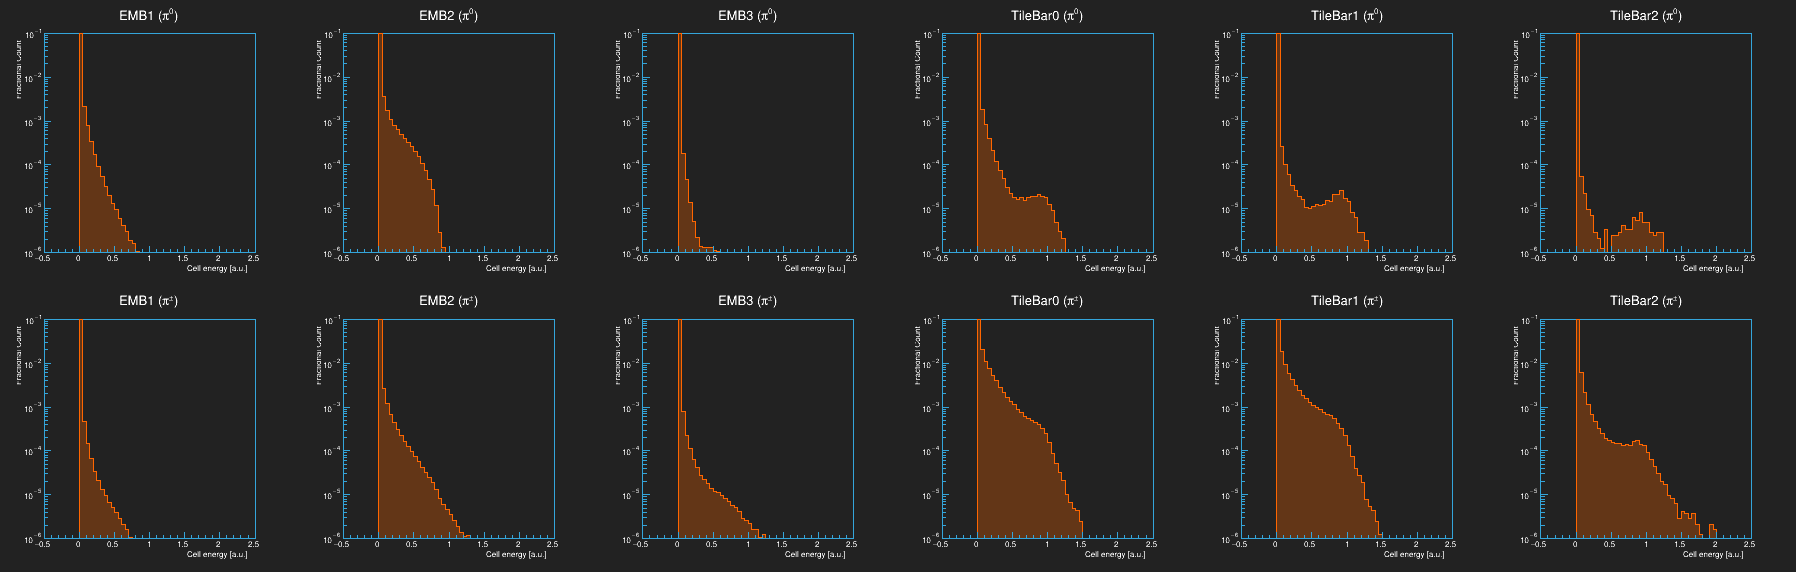

In [54]:
d = 300
c = rt.TCanvas(qu.RN(), 'c',6 * d,2 * d)
c.Divide(6,2)

hists = {}
for key in pdata.keys():
    hists[key] = {
        layer:rt.TH1F(qu.RN(),'{} ({})'.format(layer,pi_latex[key]) + ';Cell energy [a.u.];Fractional Count',nbins,e_min,e_max)
        for layer in layers
    }
    
i = 0
for key in pdata.keys():
    for layer,h in hists[key].items():
        c.cd(i+1)
        for j in range(nbins): h.SetBinContent(j+1, np_hists[key][layer][j])
        h.Scale(1./h.Integral())
        h.SetLineColor(plotstyle.curve)
        h.SetFillColorAlpha(plotstyle.curve, 0.3)
        h.Draw('HIST')
        rt.gPad.SetLogy()
        h.SetMinimum(1.0e-6)
        h.SetMaximum(1.0e-1)
        i += 1
        
c.Draw()
c.SaveAs(plotpath + 'cell_energies.png')

Even our simplest networks (our "flat classifiers") are probably exploiting some of the differences we see here between distributions. Note that the y-axis is on a log scale, so even though we see some regions where one distribution's tail goes out farther than the other, these only correspond with a relatively small number of clusters and thus might only give us limited discriminating power on their own.